In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [ ]:
%%capture
!unzip FRAC_final.zip
!unzip FRACTALS_0.zip

In [ ]:
all_data1 = np.array([(cv2.imread('FRAC_'+str(i)+'.jpeg',cv2.IMREAD_GRAYSCALE)/255).reshape(400,400,1) for i in range(0,500)])
all_data2 = np.array([(cv2.imread('FRAC_final_'+str(i)+'.jpeg',cv2.IMREAD_GRAYSCALE)/255).reshape(400,400,1) for i in range(500,1500)])
all_data = np.vstack((all_data1,all_data2))
print(all_data.shape)

(1500, 400, 400, 1)


(1500,)
0.003813651776500073
0.036317706029780336


(array([501., 241., 192., 114., 113.,  94.,  76.,  70.,  74.,  25.]),
 array([0.00381365, 0.00706406, 0.01031446, 0.01356487, 0.01681527,
        0.02006568, 0.02331608, 0.02656649, 0.0298169 , 0.0330673 ,
        0.03631771]),
 <a list of 10 Patch objects>)

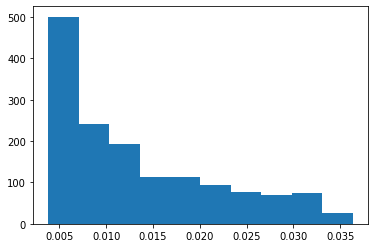

In [ ]:
# Gradient function
def mean_abs_grads(X):
    row = np.mean(np.array(list(map(lambda x1,x2: np.abs(x1[1:] - x2[0:-1]) ,X,X))))
    X = X.T
    col = np.mean(np.array(list(map(lambda x1,x2: np.abs(x1[1:] - x2[0:-1]) ,X,X))))
    return (row+col)/2
    
# Get the gradients
mean_gradients = np.array([mean_abs_grads(all_data[i].reshape(400,400)) for i in range(0,all_data.shape[0])])
print(mean_gradients.shape)
print(mean_gradients.min())
print(mean_gradients.max())
plt.hist(mean_gradients)

In [ ]:
all_labels1 = np.array(pd.read_csv('cvalues_0.csv')[0:500])
all_labels2 = np.array(pd.read_csv('cvalues_final.csv')[500:1500])
all_labels = np.vstack((all_labels1,all_labels2))
print(all_labels.shape)

(1500, 2)


In [ ]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data,all_labels,test_size=0.2,random_state=21)

all_data = None
all_data1 = None
all_data2 = None
all_labels = None
all_labels1 = None
all_labels2 = None

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=1/10,
    width_shift_range=1/10,
    height_shift_range=1/10,
    shear_range=1/10,
    zoom_range = 1/10,
    data_format='channels_last'
)
datagen.fit(X_train)

In [ ]:
# Let's build and train a CNN
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.pooling import AveragePooling2D

visible = Input(shape=(400,400,1))

conv1 = Conv2D(64, kernel_size=5, activation='softsign',padding='same')(visible)
conv2 = Conv2D(64, kernel_size=3, activation='softsign',padding='valid')(conv1)
pool1 = MaxPooling2D(pool_size=2)(conv2)

conv3 = Conv2D(32, kernel_size=5, activation='softsign',padding='same')(pool1)
conv4 = Conv2D(32, kernel_size=3, activation='softsign',padding='valid')(conv3)
pool2 = MaxPooling2D(pool_size=2)(conv4)

conv5 = Conv2D(64, kernel_size=5, activation='softsign',padding='same')(pool2)
conv6 = Conv2D(64, kernel_size=3, activation='softsign',padding='valid')(conv5)
pool3 = MaxPooling2D(pool_size=2)(conv6)

flat = Flatten()(pool3)
output = Dense(2, activation='linear')(flat)
model = Model(inputs=visible, outputs=output)

In [ ]:
import keras.optimizers as ko
model.compile(optimizer=ko.Adam(),loss='mean_squared_error')

In [ ]:
l = len(X_train)
#model.fit(datagen.flow(X_train,y_train,batch_size=8),steps_per_epoch = l/8,epochs=5,verbose=1)
model.fit(datagen.flow(X_train,y_train,batch_size=32),steps_per_epoch = l/32,epochs=10,verbose=1)
#model.fit(datagen.flow(X_train,y_train,batch_size=64),steps_per_epoch = l/64,epochs=5,verbose=1)

Epoch 1/10
38/37 [==============================] - 16s 434ms/step - loss: 10.1226
Epoch 2/10
38/37 [==============================] - 16s 426ms/step - loss: 0.0618
Epoch 3/10
38/37 [==============================] - 16s 426ms/step - loss: 0.0188
Epoch 4/10
38/37 [==============================] - 16s 428ms/step - loss: 0.0165
Epoch 5/10
38/37 [==============================] - 16s 427ms/step - loss: 0.0147
Epoch 6/10
38/37 [==============================] - 16s 426ms/step - loss: 0.0142
Epoch 7/10
38/37 [==============================] - 16s 423ms/step - loss: 0.0127
Epoch 8/10
38/37 [==============================] - 16s 422ms/step - loss: 0.0135
Epoch 9/10
38/37 [==============================] - 16s 427ms/step - loss: 0.0106
Epoch 10/10
38/37 [==============================] - 16s 426ms/step - loss: 0.0110


In [ ]:
y_predict = model.predict(X_test)

In [ ]:
total = 0
l = y_test.shape[0]
x = None
y = None
for i in range(0,l):
    err = np.abs((y_test[i] - y_predict[i])/y_test[i])*100
    total += err
    print('real:',err[0],'imag:',err[1])
print('Mean absolute error is:',total/l)
print('Total Mean:',np.sum(total/l)/2)

In [ ]:
imgs = np.array([(cv2.imread('f'+str(i+1)+'.jpeg',cv2.IMREAD_GRAYSCALE)/255).reshape(400,400,1) for i in range(0,16)])
pred = model.predict(imgs)

[-0.33125383  0.1467879 ]


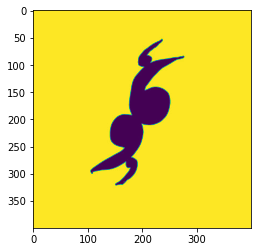

In [ ]:
print(pred[0])
plt.imshow(imgs[2].reshape(400,400))

In [ ]:
print(pred)

[[-0.6567668   0.05783728]
 [-0.24822758  0.0237752 ]
 [-0.4150931   0.29292956]
 [-0.9236525   0.08690348]
 [ 0.32501996 -0.1283124 ]
 [-0.25702098  0.81013346]
 [-0.5354232   0.3650442 ]
 [-0.5981243   0.24155162]
 [-0.88114     0.0980867 ]
 [-0.15687273  0.63032365]
 [-0.42676505  0.17767198]
 [-0.48297867  0.04779891]
 [-0.5081891   0.03765765]
 [-1.1024038   0.11133599]
 [-0.37321928  0.04338038]
 [-0.59020054 -0.09739026]]
